In [1]:
import os

os.environ['KERAS_BACKEND'] = "torch"

In [2]:
dataset_path: str = "../data/corpus.preprocessed.kickstarter_removed.256k.csv"
embeddings_path: str = "./output/abae.kickstarter_removed.256k.embeddings.model"

# Aspect size:
aspect_size = 7

In [3]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=aspect_size, random_state=42)

### Give the model the data

In [4]:
from pathlib import Path
import gensim
from core.dataset import EmbeddingsDataset

embeddings_model = gensim.models.Word2Vec.load(str(Path(embeddings_path)))
dataset = EmbeddingsDataset(dataset_path, embeddings_model)

/home/jacopo/PycharmProjects/nlp-course-project/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
INFO:gensim.utils:loading Word2Vec object from output/abae.kickstarter_removed.256k.embeddings.model
DEBUG:smart_open.smart_open_lib:{'uri': 'output/abae.kickstarter_removed.256k.embeddings.model', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'compression': 'infer_from_extension', 'transport_params': None}
INFO:gensim.utils:loading wv recursively from output/abae.kickstarter_removed.256k.embeddings.model.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO

Loading dataset from file: ../data/corpus.preprocessed.kickstarter_removed.256k.csv
Generating numeric representation for each word of ds.


Pandas Apply:   0%|          | 0/200529 [00:00<?, ?it/s]

Max sequence length calculation in progress...
We loose information on 538 points.This is 0.2682903719661495% of the dataset.
Padding sequences to max length (256).


In [13]:
embeddings = dataset.get_full_dataset()

In [8]:
model.fit(embeddings)

KMeans(n_clusters=7, random_state=42)

In [10]:
aspect_labels = model.labels_

In [14]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(embeddings, aspect_labels)
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.38644450914960954


In [26]:
embeddings.mean(axis=1).shape

(200529,)

In [21]:
aspect_labels.shape

(200529,)

/tmp/ipykernel_38382/1463709907.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


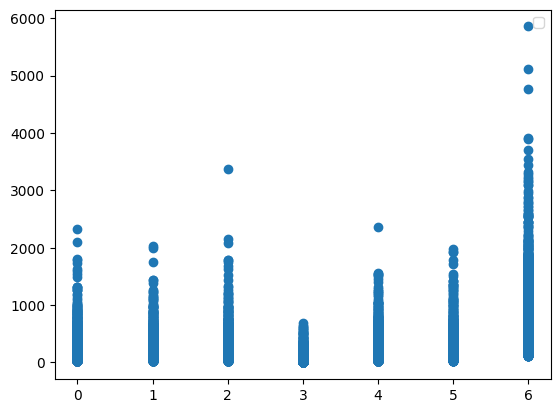

In [33]:
import matplotlib.pyplot as plt

# https://cookbook.openai.com/examples/visualizing_embeddings_in_2d
#plotting the results
plt.scatter(aspect_labels, embeddings.mean(axis=1))
plt.legend()
plt.show()

    4. Interpret the Clusters
For each cluster:
Extract the top N sentences or words closest to the cluster centroid.
Manually inspect these samples to determine the aspect they represent.
6. Evaluate Aspect Quality
Intra-cluster similarity: Sentences within a cluster should be semantically similar.
Inter-cluster distance: Clusters should be distinct from each other.
Optional: Compute silhouette scores to assess the quality of clustering.

# https://cookbook.openai.com/examples/visualizing_embeddings_in_2d

In [35]:
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
from ast import literal_eval


In [36]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(embeddings)
vis_dims.shape

(200529, 2)

/tmp/ipykernel_38382/577784299.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left")


Text(0.5, 1.0, 'Aspects t-SNE')

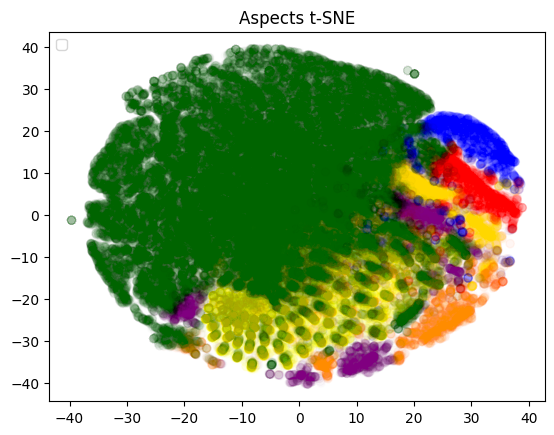

In [66]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

colors = ["red", "darkorange", "gold", "turquoise", "darkgreen", "blue", "purple", "yellow"]
x = [x for x, y in vis_dims]
y = [y for x, y in vis_dims]
color_indices = aspect_labels - 1

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=aspect_labels, cmap=colormap, alpha=0.01)

plt.legend(loc="upper left")
plt.title("Aspects t-SNE")

# Kinda hard to undestand well!

In [59]:
unique, counts = np.unique(aspect_labels, return_counts=True)
dict(zip(aspect_labels, counts))

{2: 6565, 3: 23578}

In [60]:
aspect_labels

array([2, 3, 3, ..., 6, 3, 3], dtype=int32)

In [61]:
np.bincount(aspect_labels)

array([  6565,   6097,   6143, 142851,   6862,   8433,  23578])

In [ ]:
# Most of my data is in the 4th cluster
# array([  6565,   6097,   6143, 142851,   6862,   8433,  23578])

In [67]:
centroids = model.cluster_centers_

In [70]:
for i in range(6):
    print(f"Cluster {i}:")
    top_indices = centroids[i].argsort()[-10:][::-1]
    
    top_words = top_indices
    print(top_words)
    print()

Cluster 0:


KeyboardInterrupt: 

In [71]:
from sklearn.metrics.pairwise import cosine_similarity

# Get cluster centroids
centroids = model.cluster_centers_

# Find top N words closest to each centroid
def get_top_words(centroid, model, top_n=10):
    words = model.wv.index_to_key  # Get vocabulary
    word_embeddings = np.array([model.wv[word] for word in words])
    similarities = cosine_similarity([centroid], word_embeddings).flatten()
    top_indices = similarities.argsort()[-top_n:][::-1]  # Top N closest words
    return [words[i] for i in top_indices]

# Extract top words for each cluster
top_n = 5  # Number of words to extract per cluster
for i, centroid in enumerate(centroids):
    top_words = get_top_words(centroid, dataset.embeddings_model, top_n)
    print(f"Cluster {i}: {', '.join(top_words)}")

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 256 while Y.shape[1] == 128